In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import math
import random
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# import optuna

In [7]:
# Полносвязная сеть для небольшого набора состояний
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ActorNet(nn.Module):
    def __init__(self, n_observations, n_actions, hidden_dim=64):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(n_observations, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, int(hidden_dim / 2))
        self.fc3 = nn.Linear(int(hidden_dim / 2), int(hidden_dim / 4))
        self.fc4 = nn.Linear(int(hidden_dim / 4), int(hidden_dim / 8))
        self.p = nn.Linear(int(hidden_dim / 8), n_actions*2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.p(x)
        # Возвращаем параметры, описывающие распределение
        return x[:1], torch.abs(x[1:])

class CriticNet(nn.Module):
    def __init__(self, n_observations, hidden_dim=16):
        super(CriticNet, self).__init__()
        self.fc1 = nn.Linear(n_observations, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, int(hidden_dim / 2))
        self.fc3 = nn.Linear(int(hidden_dim / 2), int(hidden_dim / 4))
        self.fc4 = nn.Linear(int(hidden_dim / 4), int(hidden_dim / 8))
        self.fc5 = nn.Linear(int(hidden_dim / 8), 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return x

In [10]:
# Агент для метода A2C
class A2CAgent:
    # Конструктор 
    def __init__(self, env, 
                 LR=0.001, DF=0.99, EPS_START=0.9, EPS_END=0.05, EPS_DECAY=100000, DEVICE='cpu', HDIM=16):
        # Среда
        self.env = env
        # Скорость обучения
        self.learning_rate = LR
        # Величина дисконтирования
        self.discount_factor = DF
        # Выбор размещения нейронных сетей
        self.device = DEVICE
        # Определяем нейронные сети целевую и политики
        # Первый параметр определяет количество наблюдений, второе число действий
        self.n_observations = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.shape[0]
        # self.actor = ActorNet(96, 3).to(self.device)
        # self.critic = CriticNet(96).to(self.device)
        self.actor = ActorNet(self.n_observations, self.n_actions, HDIM).to(self.device)
        self.critic = CriticNet(self.n_observations, HDIM).to(self.device)
        # Задаём оптимайзер для нейронной сети
        self.actor_optimizer = optim.AdamW(self.actor.parameters(), lr=self.learning_rate)
        self.critic_optimizer = optim.AdamW(self.critic.parameters(), lr=self.learning_rate)
        # Длины траекторий по эпизодам
        self.steps = []
        # Итоговое вознаграждение по эпизодам
        self.rewards = [],
        self.epsilon = EPS_START
        self.__eps_start = EPS_START
        self.__eps_end = EPS_END
        self.__eps_decay = EPS_DECAY
    
    # Оценка действия сетью Actor
    def actor_action(self, state):
        # with torch.no_grad():
        state = torch.FloatTensor(state).to(self.device)
        mean, std = self.actor(state)
        dist = torch.distributions.Normal(mean, std)
        # Эпсилон-жадная стратегия
        if np.random.rand() < self.epsilon:
            action = self.env.action_space.sample()
            action = torch.FloatTensor(action).to(self.device)
        else:
            action = dist.sample()        
        # action = dist.sample()
        log_prob = dist.log_prob(action).sum(-1, keepdim=True)
        return action.detach().to('cpu').numpy(), log_prob

    
    # Проигрываем эпизод 
    def __play_episode(self):
        steps = 0
        state, _ = self.env.reset()
        done = False
        states, actions, log_probs, rewards = [], [], [], []

        while (not done):
            action, log_prob = self.actor_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            states.append(state)
            actions.append(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state.squeeze()
            steps += 1

        # Сохраняем длину траектории
        self.steps.append(steps)
        # Сохраняем вознаграждение за эпизод            
        self.rewards.append(sum(rewards))
        # Расчитываем накопленное вознаграждение с учётом дисконтирования
        cum_rewards = np.zeros_like(rewards)
        discounted_reward = 0
        for t in reversed(range(len(rewards))):
            discounted_reward = rewards[t] + discounted_reward * self.discount_factor
            cum_rewards[t] = discounted_reward
        
        return states, actions, log_probs, rewards, cum_rewards

    # Обучение Агента
    def train(self, num_episodes=50, logfreq=20):
        # Обнуляем прошлый опыт
        self.rewards, self.steps = [], []
        for episode in tqdm(range(num_episodes)):
            # Проигрываем эпизод с ограничением по длине траектории
            states, actions, log_probs, rewards, cum_rewards = self.__play_episode()
            # Переводим результаты в тензоры для обновления сетей Actor & Critic
            states = torch.FloatTensor(np.array(states)).to(self.device)
            actions = torch.FloatTensor(np.array(actions)).to(self.device)
            log_probs = torch.cat(log_probs)
            rewards = torch.FloatTensor(np.array(rewards)).to(self.device)
            cum_rewards = torch.FloatTensor(cum_rewards).to(self.device)

            # Обновляем Critic
            self.critic_optimizer.zero_grad()
            values = self.critic(states).squeeze()
            critic_loss = F.mse_loss(values, cum_rewards)
            critic_loss.sum().backward()
            with torch.no_grad():
                values = self.critic(states).squeeze()
            self.critic_optimizer.step()

            # Обновляем Actor
            self.actor_optimizer.zero_grad()
            # Рассчитываем advantages
            advantages = cum_rewards - values
            actor_loss = -(log_probs * advantages)
            actor_loss.sum().backward()
            self.actor_optimizer.step()
            
            # Уменьшаем критерий жадности
            self.epsilon = self.__eps_end + (self.__eps_start - self.__eps_end) * \
                math.exp(-1. * sum(self.steps) / self.__eps_decay)
            # Выводим результаты с заданной частотой
            if (episode + 1)%logfreq == 0:
                print(f"Run episode {episode+1} with average reward {np.mean(self.rewards[-logfreq:]):.2f} and epsilon {self.epsilon:.4f}", end="\r")
    
    # Отображаем результаты обучения
    def plot_rewards(self, window_size=10):
        # Сгладим графики
        smoothed_rewards = pd.Series(self.rewards).rolling(window_size, min_periods=window_size).mean()
        smoothed_steps = pd.Series(self.steps).rolling(window_size, min_periods=window_size).mean()

        plt.figure(figsize=(8, 12))
        plt.subplot(2, 1, 1)
        plt.plot(self.rewards)
        plt.plot(smoothed_rewards)
        plt.xlabel('Эпизод')
        plt.ylabel('Суммарное вознаграждение')
        plt.title('Оценка вознаграждения')

        plt.subplot(2, 1, 2)
        plt.plot(self.steps)
        plt.plot(smoothed_steps)
        plt.xlabel('Эпизод')
        plt.ylabel('Длина траектории')
        plt.title('Оценка длины траектории')

        plt.tight_layout()
        plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

  5%|▌         | 25/500 [05:38<1:08:13,  8.62s/it]

 10%|█         | 50/500 [07:39<36:13,  4.83s/it]  

 15%|█▌        | 75/500 [09:40<34:04,  4.81s/it]

 20%|██        | 100/500 [11:41<32:02,  4.81s/it]

 25%|██▌       | 125/500 [13:41<30:03,  4.81s/it]

 30%|███       | 150/500 [15:44<27:57,  4.79s/it]

 35%|███▌      | 175/500 [17:44<25:57,  4.79s/it]

 40%|████      | 200/500 [19:43<23:55,  4.78s/it]

 45%|████▌     | 225/500 [21:43<21:54,  4.78s/it]

 50%|█████     | 250/500 [23:43<19:54,  4.78s/it]

 55%|█████▌    | 275/500 [25:42<17:52,  4.77s/it]

 60%|██████    | 300/500 [27:42<15:55,  4.78s/it]

 65%|██████▌   | 325/500 [29:43<14:01,  4.81s/it]

 70%|███████   | 350/500 [31:42<11:52,  4.75s/it]

 75%|███████▌  | 375/500 [33:41<09:54,  4.75s/it]

 80%|████████  | 400/500 [35:40<07:54,  4.75s/it]

 85%|████████▌ | 425/500 [37:39<06:03,  4.84s/it]

 90%|█████████ | 450/500 [39:42<04:00,  4.82s/it]

 95%|█████████▌| 475/500 [41:45<02:02,  4.91s/it]

100%|██████████| 500/500 [43:47<00:00,  5.26s/it]

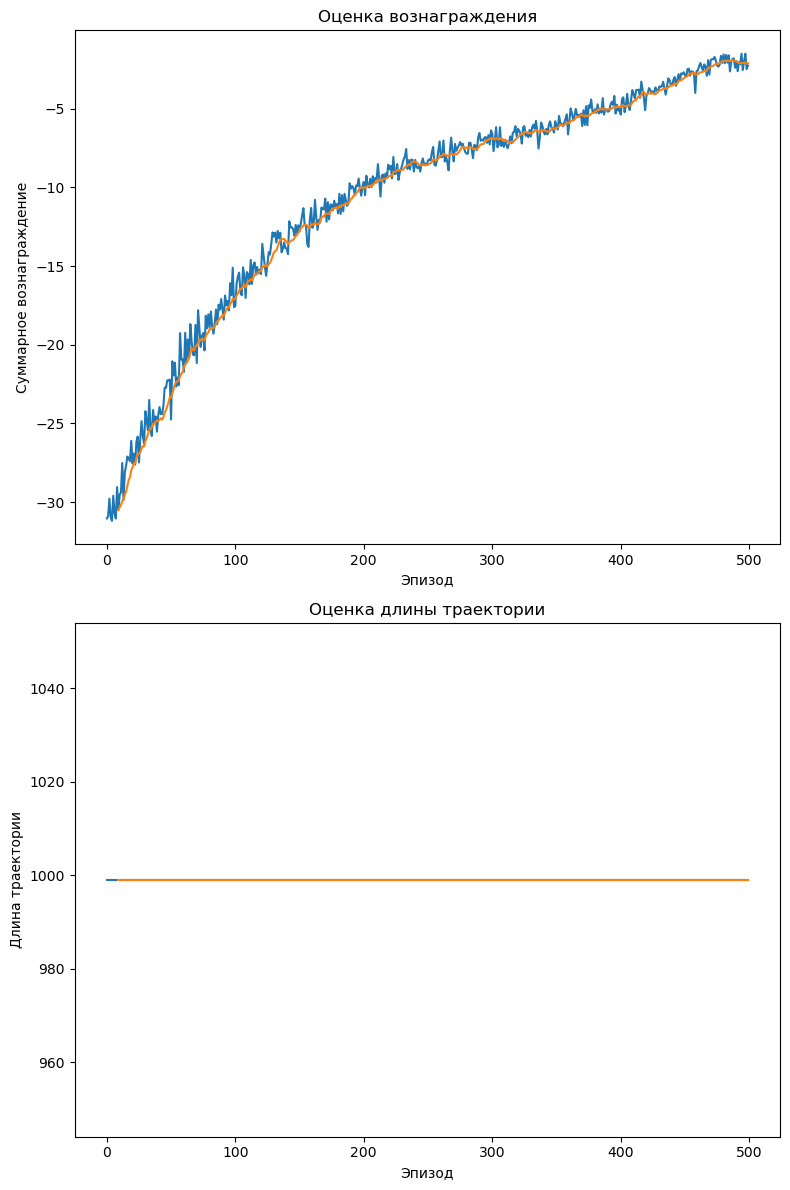

In [12]:
agent4 = A2CAgent(gym.make("MountainCarContinuous-v0"),
                  LR=1E-4, HDIM=64, DEVICE="mps")

agent4.train(500, 25)
agent4.plot_rewards()

  2%|▏         | 10/500 [00:52<42:48,  5.24s/it]

  4%|▍         | 20/500 [01:44<40:13,  5.03s/it]

  6%|▌         | 30/500 [02:33<38:50,  4.96s/it]

  8%|▊         | 40/500 [03:23<37:28,  4.89s/it]

 10%|█         | 50/500 [04:11<36:12,  4.83s/it]

 12%|█▏        | 60/500 [04:59<35:18,  4.81s/it]

 14%|█▍        | 70/500 [05:48<34:30,  4.81s/it]

 16%|█▌        | 80/500 [06:36<33:36,  4.80s/it]

 18%|█▊        | 90/500 [07:24<32:45,  4.79s/it]

 20%|██        | 100/500 [08:12<31:56,  4.79s/it]

 22%|██▏       | 110/500 [09:00<31:05,  4.78s/it]

 24%|██▍       | 120/500 [09:47<30:07,  4.76s/it]

 26%|██▌       | 130/500 [10:35<29:18,  4.75s/it]

 28%|██▊       | 140/500 [11:23<29:00,  4.83s/it]

 30%|███       | 150/500 [12:12<28:19,  4.86s/it]

 32%|███▏      | 160/500 [13:00<28:04,  4.95s/it]

 34%|███▍      | 170/500 [13:51<27:59,  5.09s/it]

 36%|███▌      | 180/500 [14:39<25:36,  4.80s/it]

 38%|███▊      | 190/500 [15:29<25:59,  5.03s/it]

 40%|████      | 200/500 [16:18<24:06,  4.82s/it]

 42%|████▏     | 210/500 [17:07<23:18,  4.82s/it]

 44%|████▍     | 220/500 [17:55<22:30,  4.82s/it]

 46%|████▌     | 230/500 [18:43<21:41,  4.82s/it]

 48%|████▊     | 240/500 [19:32<20:43,  4.78s/it]

 50%|█████     | 250/500 [20:19<19:54,  4.78s/it]

 52%|█████▏    | 260/500 [21:07<19:06,  4.78s/it]

 54%|█████▍    | 270/500 [21:54<18:11,  4.75s/it]

 56%|█████▌    | 280/500 [22:42<17:27,  4.76s/it]

 58%|█████▊    | 290/500 [23:30<16:42,  4.78s/it]

 60%|██████    | 300/500 [24:18<15:56,  4.78s/it]

 62%|██████▏   | 310/500 [25:06<15:30,  4.90s/it]

 64%|██████▍   | 320/500 [25:55<14:29,  4.83s/it]

 66%|██████▌   | 330/500 [26:43<13:27,  4.75s/it]

 68%|██████▊   | 340/500 [27:30<12:36,  4.73s/it]

 70%|███████   | 350/500 [28:17<11:47,  4.72s/it]

 72%|███████▏  | 360/500 [29:04<11:02,  4.73s/it]

 74%|███████▍  | 370/500 [29:52<10:17,  4.75s/it]

 76%|███████▌  | 380/500 [30:39<09:29,  4.75s/it]

 78%|███████▊  | 390/500 [31:27<08:41,  4.75s/it]

 80%|████████  | 400/500 [32:14<07:57,  4.78s/it]

 82%|████████▏ | 410/500 [33:02<07:09,  4.77s/it]

 84%|████████▍ | 420/500 [33:50<06:21,  4.77s/it]

 86%|████████▌ | 430/500 [34:37<05:33,  4.77s/it]

 88%|████████▊ | 440/500 [35:25<04:46,  4.77s/it]

 90%|█████████ | 450/500 [36:13<03:59,  4.78s/it]

 92%|█████████▏| 460/500 [37:01<03:11,  4.79s/it]

 94%|█████████▍| 470/500 [37:48<02:23,  4.79s/it]

 96%|█████████▌| 480/500 [38:36<01:35,  4.79s/it]

 98%|█████████▊| 490/500 [39:24<00:47,  4.78s/it]

100%|██████████| 500/500 [40:12<00:00,  4.82s/it]

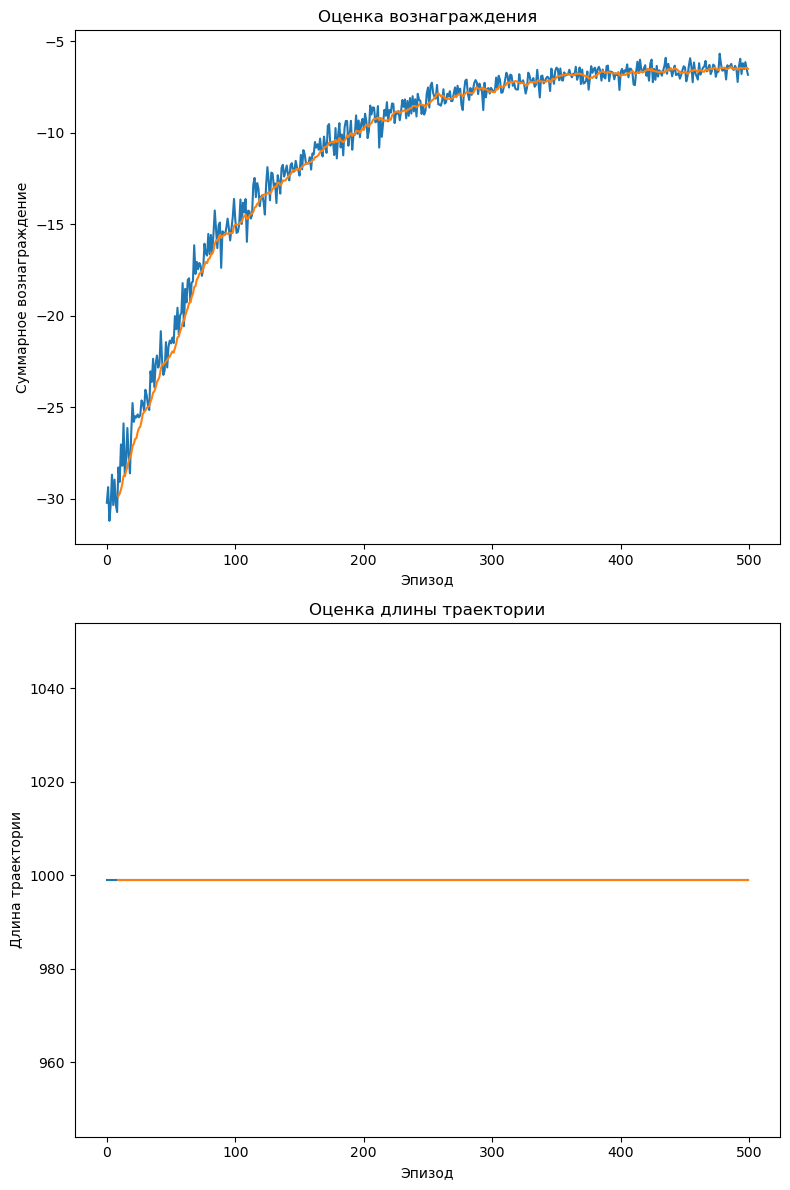

In [13]:
agent5 = A2CAgent(gym.make("MountainCarContinuous-v0"),
                  LR=1E-3, HDIM=64, DEVICE="mps")

agent5.train(500, 10)
agent5.plot_rewards()